In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('train_v2.csv')
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [4]:
img_size = 64

In [24]:
# input_dir = r'e:\kaggle\planet_amazon'
input_dir = 'inputs'

x_train = []
x_test = []
y_train = []
for f, tags in tqdm(df_train.values, miniters=1000):
    f_name = '{}.jpg'.format(f)
#     print(os.path.join(input_dir, 'train-jpg', f_name))
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (img_size, img_size)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [00:33<00:00, 1216.60it/s]


(40479, 64, 64, 3)
(40479, 17)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [27]:
from keras.models import load_model
model = load_model('starter_0.883.h5')

In [28]:
p_train = model.predict(X_train, batch_size=128)
p_valid = model.predict(X_valid, batch_size=128)

In [30]:
print(fbeta_score(Y_train, np.array(p_train) > 0.2, beta=2, average='samples'))
print(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.895617823832
0.897006037648


In [31]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter, defaultdict

labels = df_train['tags'].apply(lambda x: x.split(' '))
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')

In [43]:
def decode(one_hot_data):
    decoded = []
    for i in range(len(one_hot_data)):
        decoded.append(np.sum(list(reversed([(v*2**i) for i,v in enumerate(reversed(one_hot_data[i]))]))))
    return np.array(decoded)

In [44]:
Y_valid_dec = decode(Y_valid)

In [70]:
distr = np.zeros(Y_valid_dec.max()+1)
for d in Y_valid_dec:
    distr[d]+=1
distr.argmax()

40960

In [76]:
distr[:15000].argmax()

8320

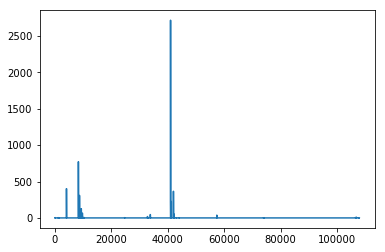

In [75]:
plt.plot(distr)
plt.show()

In [132]:
def encode(num):
    l = [int(x) for x in bin(num)[2:]]
    while len(l) < 17:
        l.insert(0,0)
    return l

In [133]:
most_common = np.array(encode(40960))
# most_common = np.ones(17)
y_ref = np.empty((len(Y_valid), len(most_common)))
for i in range(len(Y_valid)):
    y_ref[i] = most_common.copy()
print(fbeta_score(Y_valid, y_ref, beta=2, average='samples'))

0.642895778949


In [136]:
most_common = np.array(encode(8320))
y_ref = np.empty((len(Y_valid), len(most_common)))
for i in range(len(Y_valid)):
    y_ref[i] = most_common.copy()
print(fbeta_score(Y_valid, y_ref, beta=2, average='samples'))

0.445777827076


In [144]:
most_common = np.array([1 if i == 1 or j == 1 else 0 for i,j in zip(encode(40960), encode(8320))])
y_ref = np.empty((len(Y_valid), len(most_common)))
for i in range(len(Y_valid)):
    y_ref[i] = most_common.copy()
print(fbeta_score(Y_valid, y_ref, beta=2, average='samples'))

0.662589181318
